## Installations and Imports :



In [ ]:
!pip install sklearn librosa mir_eval tensorflow tf2crf

In [ ]:
#!/usr/bin/env python3
from numpy.lib.npyio import save
import sklearn
import sys
import numpy as np
import argparse

from numpy.lib.npyio import save
from ACR_Training.Models import MLP, MLP_scalered, CRNN, CRNN_basic, CRNN_efficient, CRNN_CRF, MLP2RNN, CRNN_2, BassVsThird
from ACR_Training.Datasets import IsophonicsDataset, BillboardDataset
from ACR_Training.Evaluator import Evaluator
import sklearn
import sys

# Beatles Dataset

## CRNN based on Efficient Net

[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1000, 252, 1)]    0         
_________________________________________________________________
efficientnet-b0 (Functional) [(None, 1280), (None, 32, 4048988   
_________________________________________________________________
reshape (Reshape)            (None, 1000, 1008)        0         
_________________________________________________________________
bidirectional (Bidirectional (None, 1000, 1024)        4675584   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1000, 64)          203136    
_________________________________________________________________
dense (Dense)                (None, 1000, 25)          16

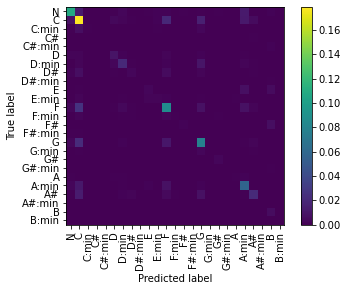

In [ ]:
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


# DATA PREPARATION
# Train data
train_x, train_y = IsophonicsDataset.load_preprocessed_dataset("../input/beatles/Beatles1000_cqt_train.ds")
n_samples, n_frames, n_chromas = train_x.shape
train_x = train_x.reshape((n_samples,n_frames,n_chromas,1))
# Test data
test_x, test_y = IsophonicsDataset.load_preprocessed_dataset("../input/beatles/Beatles1000_cqt_test.ds")
# Scaler
preprocessor = StandardScaler()
preprocessor.fit(train_x.reshape((-1, 252)))
train_x = preprocessor.transform(train_x.reshape((-1, 252))).reshape((-1, n_frames, n_chromas, 1))


# TRAIN
# Create model
crnn_model = CRNN_efficient(input_shape=(n_frames, n_chromas, 1), output_classes=25)
# Train model
crnn_model.fit(train_x, train_y, epochs=50)


# EVALUATE
# Collecting
grouped_test_x, grouped_test_y = [], []
gold, predictions = [], []
for songs_features, songs_labels in zip(test_x, test_y):
    songs_features_transformed = preprocessor.transform(songs_features.reshape((-1, n_chromas))).reshape((-1, n_frames, n_chromas, 1))
    gold.append(songs_labels)
    predictions.append(crnn_model.predict(songs_features_transformed))
    for feature_sequence, label_sequence in zip(songs_features_transformed, songs_labels):
        grouped_test_x.append(feature_sequence)
        grouped_test_y.append(label_sequence)
grouped_test_x = np.array(grouped_test_x)
grouped_test_y = np.array(grouped_test_y)

# Accuracy
print("\n","Test accuracy: ", "{:.2f}".format(100*crnn_model.score(grouped_test_x, grouped_test_y)), "%", "\n")
crnn_model.display_confusion_matrix(grouped_test_x, grouped_test_y)
# Weighted Accuracy
print("\n","Testweighted  accuracy: ", 
      "{:.2f}".format(100*Evaluator.eval_isophonics_testset(gold, predictions)),
      "%", "\n")

### Original Beatles songs


[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1000, 252, 1)]    0         
_________________________________________________________________
efficientnet-b0 (Functional) [(None, 1280), (None, 32, 4048988   
_________________________________________________________________
reshape_1 (Reshape)          (None, 1000, 1008)        0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1000, 1024)        4675584   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1000, 64)          203136    
_________________________________________________________________
dense_1 (Dense)              (None, 1000, 25)          

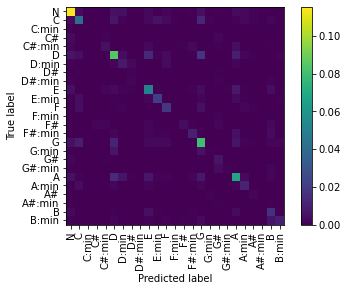

In [ ]:
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


# DATA PREPARATION
# Train data
x, y = IsophonicsDataset.load_preprocessed_dataset("../input/beatles/Beatles1000_cqt_original_train.ds")
train_x, train_y = [] ,[]
for i, j in zip(x, y):
    for k, l in zip(i, j):
        train_x.append(k)
        train_y.append(l)
train_x = np.array(train_x)
train_y = np.array(train_y)
n_samples, n_frames, n_chromas = train_x.shape
train_x = train_x.reshape((n_samples,n_frames,n_chromas,1))
# Test data
test_x, test_y = IsophonicsDataset.load_preprocessed_dataset("../input/beatles/Beatles1000_cqt_original_test.ds")
# Scaler
preprocessor = StandardScaler()
preprocessor.fit(train_x.reshape((-1, 252)))
train_x = preprocessor.transform(train_x.reshape((-1, 252))).reshape((-1, n_frames, n_chromas, 1))


# TRAIN
# Create model
crnn_model = CRNN_efficient(input_shape=(n_frames, n_chromas, 1), output_classes=25)
# Train model
crnn_model.fit(train_x, train_y, [], [], epochs=50)


# EVALUATE
# Collecting
grouped_test_x, grouped_test_y = [], []
gold, predictions = [], []
for songs_features, songs_labels in zip(test_x, test_y):
    songs_features_transformed = preprocessor.transform(songs_features.reshape((-1, n_chromas))).reshape((-1, n_frames, n_chromas, 1))
    gold.append(songs_labels)
    predictions.append(crnn_model.predict(songs_features_transformed))
    for feature_sequence, label_sequence in zip(songs_features_transformed, songs_labels):
        grouped_test_x.append(feature_sequence)
        grouped_test_y.append(label_sequence)
grouped_test_x = np.array(grouped_test_x)
grouped_test_y = np.array(grouped_test_y)

# Accuracy
print("\n","Test accuracy: ", "{:.2f}".format(100*crnn_model.score(grouped_test_x, grouped_test_y)), "%", "\n")
crnn_model.display_confusion_matrix(grouped_test_x, grouped_test_y)
# Weighted Accuracy
print("\n","Testweighted  accuracy: ", 
      "{:.2f}".format(100*Evaluator.eval_isophonics_testset(gold, predictions)),
      "%", "\n")

## Basic CRNN

[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 1000, 252, 16)     160       
_________________________________________________________________
batch_normalization_6 (Batch (None, 1000, 252, 16)     64        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 1000, 252, 16)     2320      
_________________________________________________________________
batch_normalization_7 (Batch (None, 1000, 252, 16)     64        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1000, 252, 16)     2320      
_________________________________________________________________
batch_normalization_8 (Batch (None, 1000, 252, 16)

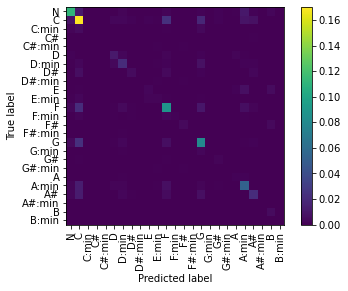

In [ ]:
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


# DATA PREPARATION
# Train data
train_x, train_y = IsophonicsDataset.load_preprocessed_dataset("../input/beatles/Beatles1000_cqt_train.ds")
n_samples, n_frames, n_chromas = train_x.shape
train_x = train_x.reshape((n_samples,n_frames,n_chromas,1))
# Test data
test_x, test_y = IsophonicsDataset.load_preprocessed_dataset("../input/beatles/Beatles1000_cqt_test.ds")
# Scaler
preprocessor = StandardScaler()
preprocessor.fit(train_x.reshape((-1, 252)))
train_x = preprocessor.transform(train_x.reshape((-1, 252))).reshape((-1, n_frames, n_chromas, 1))


# TRAIN
# Create model
crnn_model = CRNN_basic(input_shape=(n_frames, n_chromas, 1), output_classes=25)
# Train model
crnn_model.fit(train_x, train_y, epochs=50)


# EVALUATE
# Collecting
grouped_test_x, grouped_test_y = [], []
gold, predictions = [], []
for songs_features, songs_labels in zip(test_x, test_y):
    songs_features_transformed = preprocessor.transform(songs_features.reshape((-1, n_chromas))).reshape((-1, n_frames, n_chromas, 1))
    gold.append(songs_labels)
    predictions.append(crnn_model.predict(songs_features_transformed))
    for feature_sequence, label_sequence in zip(songs_features_transformed, songs_labels):
        grouped_test_x.append(feature_sequence)
        grouped_test_y.append(label_sequence)
grouped_test_x = np.array(grouped_test_x)
grouped_test_y = np.array(grouped_test_y)

# Accuracy
print("\n","Test accuracy: ", "{:.2f}".format(100*crnn_model.score(grouped_test_x, grouped_test_y)), "%", "\n")
crnn_model.display_confusion_matrix(grouped_test_x, grouped_test_y)
# Weighted Accuracy
print("\n","Testweighted  accuracy: ", 
      "{:.2f}".format(100*Evaluator.eval_isophonics_testset(gold, predictions)),
      "%", "\n")

### Original Beatles songs



[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1000, 252, 16)     160       
_________________________________________________________________
batch_normalization (BatchNo (None, 1000, 252, 16)     64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1000, 252, 16)     2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 252, 16)     64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1000, 252, 16)     2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000, 252, 16)  

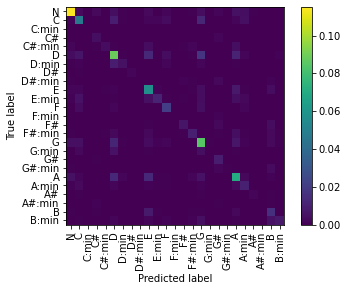

In [ ]:
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


# DATA PREPARATION
# Train data
x, y = IsophonicsDataset.load_preprocessed_dataset("../input/beatles/Beatles1000_cqt_original_train.ds")
train_x, train_y = [] ,[]
for i, j in zip(x, y):
    for k, l in zip(i, j):
        train_x.append(k)
        train_y.append(l)
train_x = np.array(train_x)
train_y = np.array(train_y)
n_samples, n_frames, n_chromas = train_x.shape
train_x = train_x.reshape((n_samples,n_frames,n_chromas,1))
# Test data
test_x, test_y = IsophonicsDataset.load_preprocessed_dataset("../input/beatles/Beatles1000_cqt_original_test.ds")
# Scaler
preprocessor = StandardScaler()
preprocessor.fit(train_x.reshape((-1, 252)))
train_x = preprocessor.transform(train_x.reshape((-1, 252))).reshape((-1, n_frames, n_chromas, 1))


# TRAIN
# Create model
crnn_model = CRNN_basic(input_shape=(n_frames, n_chromas, 1), output_classes=25)
# Train model
crnn_model.fit(train_x, train_y, [], [], epochs=50)


# EVALUATE
# Collecting
grouped_test_x, grouped_test_y = [], []
gold, predictions = [], []
for songs_features, songs_labels in zip(test_x, test_y):
    songs_features_transformed = preprocessor.transform(songs_features.reshape((-1, n_chromas))).reshape((-1, n_frames, n_chromas, 1))
    gold.append(songs_labels)
    predictions.append(crnn_model.predict(songs_features_transformed))
    for feature_sequence, label_sequence in zip(songs_features_transformed, songs_labels):
        grouped_test_x.append(feature_sequence)
        grouped_test_y.append(label_sequence)
grouped_test_x = np.array(grouped_test_x)
grouped_test_y = np.array(grouped_test_y)

# Accuracy
print("\n","Test accuracy: ", "{:.2f}".format(100*crnn_model.score(grouped_test_x, grouped_test_y)), "%", "\n")
crnn_model.display_confusion_matrix(grouped_test_x, grouped_test_y)
# Weighted Accuracy
print("\n","Testweighted  accuracy: ", 
      "{:.2f}".format(100*Evaluator.eval_isophonics_testset(gold, predictions)),
      "%", "\n")

## CRNN with CRF

[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
[INFO] The Preprocessed Isophonics Dataset was loaded successfully.


/opt/conda/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000, 252, 1)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1000, 252, 16)     160       
_________________________________________________________________
batch_normalization (BatchNo (None, 1000, 252, 16)     64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1000, 252, 16)     2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 252, 16)     64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1000, 252, 16)     2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000, 252, 16)     64    

/opt/conda/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)
/opt/conda/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)


9/9 - 11s - loss_val: 2117.6487 - val_accuracy: 0.5677

 Test accuracy:  56.77 % 


 Testweighted  accuracy:  3.91 % 



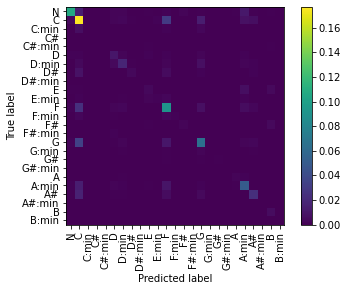

In [ ]:
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


# DATA PREPARATION
# Train data
train_x, train_y = IsophonicsDataset.load_preprocessed_dataset("../input/beatles/Beatles1000_cqt_train.ds")
n_samples, n_frames, n_chromas = train_x.shape
train_x = train_x.reshape((n_samples,n_frames,n_chromas,1))
# Test data
test_x, test_y = IsophonicsDataset.load_preprocessed_dataset("../input/beatles/Beatles1000_cqt_test.ds")
# Scaler
preprocessor = StandardScaler()
preprocessor.fit(train_x.reshape((-1, 252)))
train_x = preprocessor.transform(train_x.reshape((-1, 252))).reshape((-1, n_frames, n_chromas, 1))


# TRAIN
# Create model
crnn_model = CRNN_CRF(input_shape=(n_frames, n_chromas, 1), output_classes=25)
# Train model
crnn_model.fit(train_x, train_y, [], [], epochs=50)


# EVALUATE
# Collecting
grouped_test_x, grouped_test_y = [], []
gold, predictions = [], []
for songs_features, songs_labels in zip(test_x, test_y):
    songs_features_transformed = preprocessor.transform(songs_features.reshape((-1, n_chromas))).reshape((-1, n_frames, n_chromas, 1))
    gold.append(songs_labels)
    predictions.append((crnn_model.predict(songs_features_transformed)).reshape((-1,n_frames,1)))
    for feature_sequence, label_sequence in zip(songs_features_transformed, songs_labels):
        grouped_test_x.append(feature_sequence)
        grouped_test_y.append(label_sequence)
grouped_test_x = np.array(grouped_test_x)
grouped_test_y = np.array(grouped_test_y)

# Accuracy
print("\n","Test accuracy: ", "{:.2f}".format(100*crnn_model.score(grouped_test_x, grouped_test_y)), "%", "\n")
crnn_model.display_confusion_matrix(grouped_test_x, grouped_test_y)
# Weighted Accuracy
print("\n","Testweighted  accuracy: ", 
      "{:.2f}".format(100*Evaluator.eval_isophonics_testset(gold, predictions)),
      "%", "\n")

### Original Beatles songs

[INFO] The Preprocessed Isophonics Dataset was loaded successfully.
[INFO] The Preprocessed Isophonics Dataset was loaded successfully.


/opt/conda/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000, 252, 1)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 1000, 252, 16)     160       
_________________________________________________________________
batch_normalization (BatchNo (None, 1000, 252, 16)     64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1000, 252, 16)     2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000, 252, 16)     64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1000, 252, 16)     2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1000, 252, 16)     64    

/opt/conda/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)
/opt/conda/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)


9/9 - 12s - loss_val: 2009.1456 - val_accuracy: 0.5445

 Test accuracy:  54.45 % 


 Testweighted  accuracy:  3.91 % 



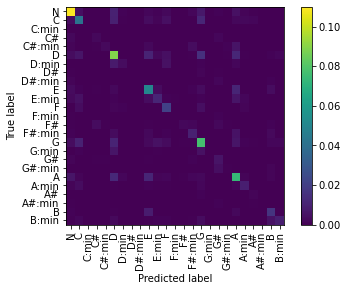

In [ ]:
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline


# DATA PREPARATION
# Train data
x, y = IsophonicsDataset.load_preprocessed_dataset("../input/beatles/Beatles1000_cqt_original_train.ds")
train_x, train_y = [] ,[]
for i, j in zip(x, y):
    for k, l in zip(i, j):
        train_x.append(k)
        train_y.append(l)
train_x = np.array(train_x)
train_y = np.array(train_y)
n_samples, n_frames, n_chromas = train_x.shape
train_x = train_x.reshape((n_samples,n_frames,n_chromas,1))
# Test data
test_x, test_y = IsophonicsDataset.load_preprocessed_dataset("../input/beatles/Beatles1000_cqt_original_test.ds")
# Scaler
preprocessor = StandardScaler()
preprocessor.fit(train_x.reshape((-1, 252)))
train_x = preprocessor.transform(train_x.reshape((-1, 252))).reshape((-1, n_frames, n_chromas, 1))


# TRAIN
# Create model
crnn_model = CRNN_CRF(input_shape=(n_frames, n_chromas, 1), output_classes=25)
# Train model
crnn_model.fit(train_x, train_y, [], [], epochs=50)


# EVALUATE
# Collecting
grouped_test_x, grouped_test_y = [], []
gold, predictions = [], []
for songs_features, songs_labels in zip(test_x, test_y):
    songs_features_transformed = preprocessor.transform(songs_features.reshape((-1, n_chromas))).reshape((-1, n_frames, n_chromas, 1))
    gold.append(songs_labels)
    predictions.append((crnn_model.predict(songs_features_transformed)).reshape((-1,n_frames,1)))
    for feature_sequence, label_sequence in zip(songs_features_transformed, songs_labels):
        grouped_test_x.append(feature_sequence)
        grouped_test_y.append(label_sequence)
grouped_test_x = np.array(grouped_test_x)
grouped_test_y = np.array(grouped_test_y)

# Accuracy
print("\n","Test accuracy: ", "{:.2f}".format(100*crnn_model.score(grouped_test_x, grouped_test_y)), "%", "\n")
crnn_model.display_confusion_matrix(grouped_test_x, grouped_test_y)
# Weighted Accuracy
print("\n","Testweighted  accuracy: ", 
      "{:.2f}".format(100*Evaluator.eval_isophonics_testset(gold, predictions)),
      "%", "\n")